# Lee–Carter boosted with Random Forest

This code implements a methodology on improving the Lee–Carter mortality predictions 
with a random forest algorithm presented in the paper: 
https://link.springer.com/article/10.1007/s00500-019-04427-z 

### Useful links:

- https://cran.r-project.org/web/packages/StMoMo/vignettes/StMoMoVignette.pdf
- https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest
- https://cran.r-project.org/web/packages/MortalitySmooth/MortalitySmooth.pdf
- https://www.mortality.org/

## 1. Preliminaries
In this step we will load libraries and set contants.

In [3]:
# Write here your username and password to HMD https://www.mortality.org/
username <- 
password <- 

# Constants
country = "AUS"
ages <- 20:100
years <- 1947:2014
genders <- c("male", "female")

library(demography)
library(StMoMo)
library(randomForest)

## 2. Lee-Carter
Firstly, we fit standard Lee-Carter model for both males and females of selected country. We collect deaths, predicted deaths, exposure (population) and ratio for further calculations.

Warning message in hmd.mx(country = country, username = username, password = password):
"NAs introduced by coercion"


StMoMo: Start fitting with gnm
Initialising
Running start-up iterations..
Running main iterations......
Done
StMoMo: Finish fitting with gnm


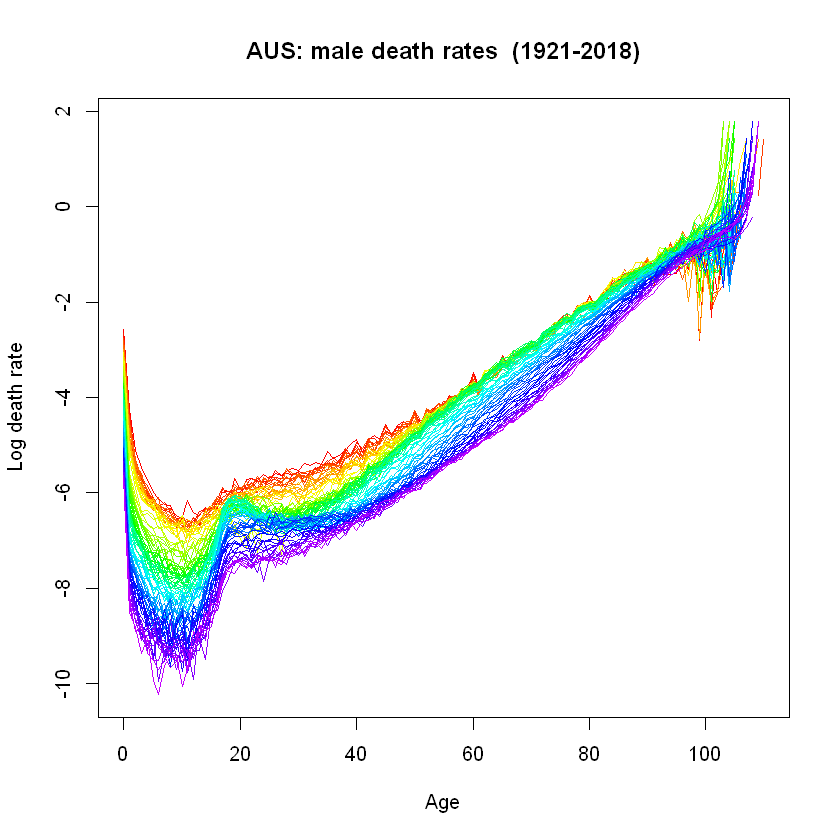

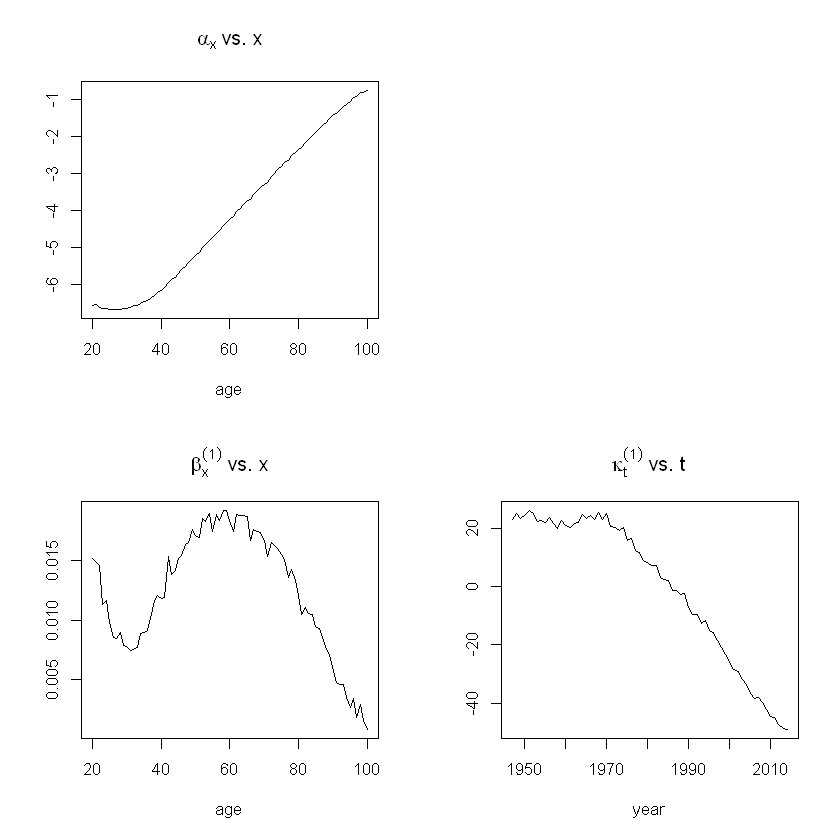

StMoMo: Start fitting with gnm
Initialising
Running start-up iterations..
Running main iterations.....
Done


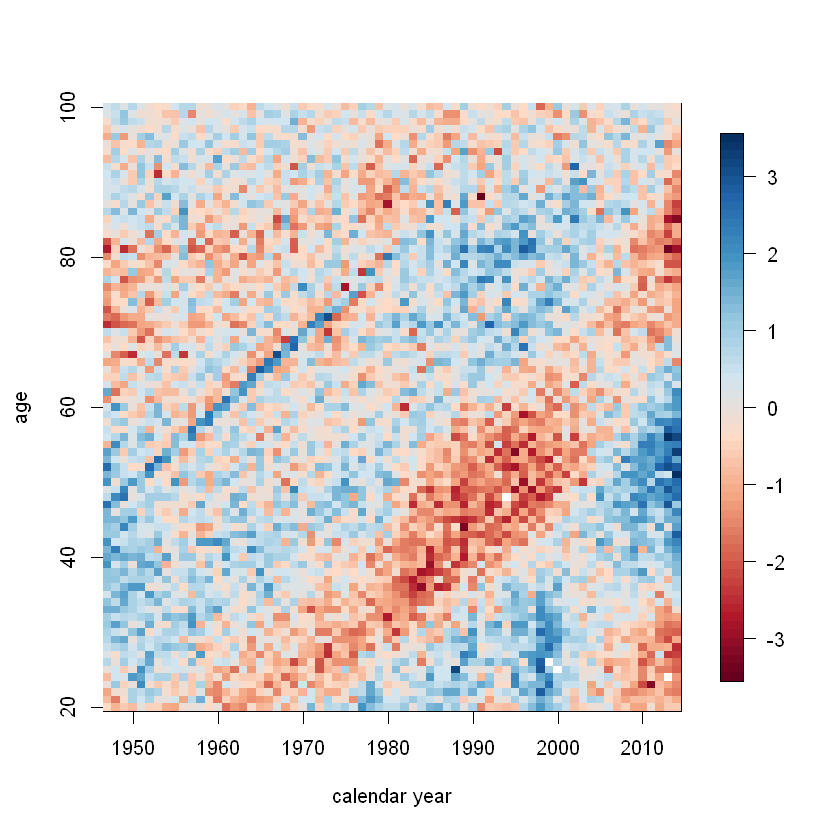

StMoMo: Finish fitting with gnm


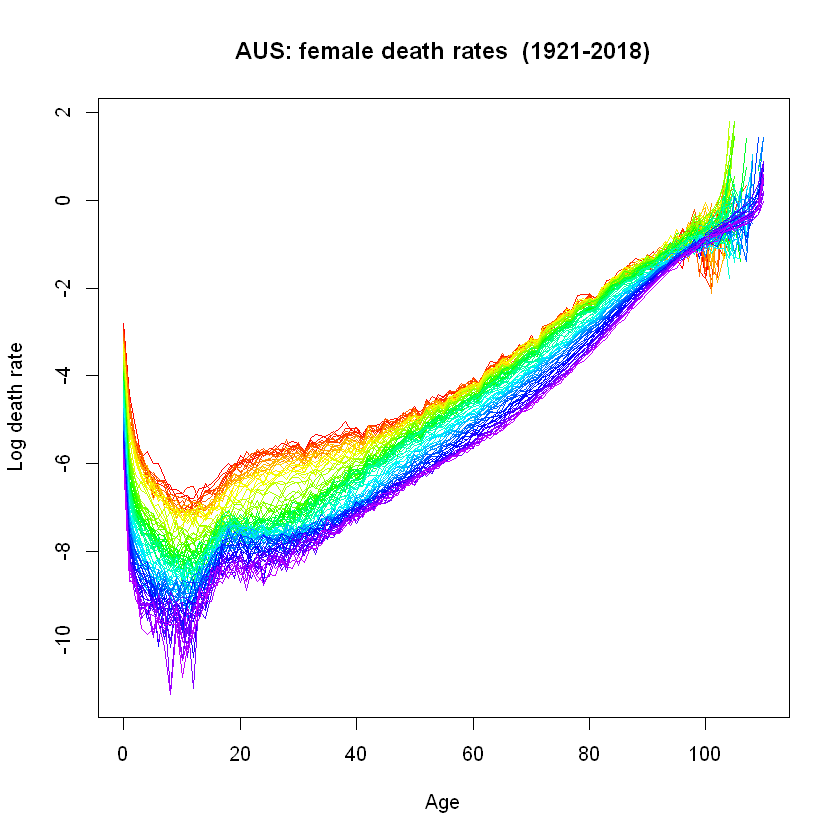

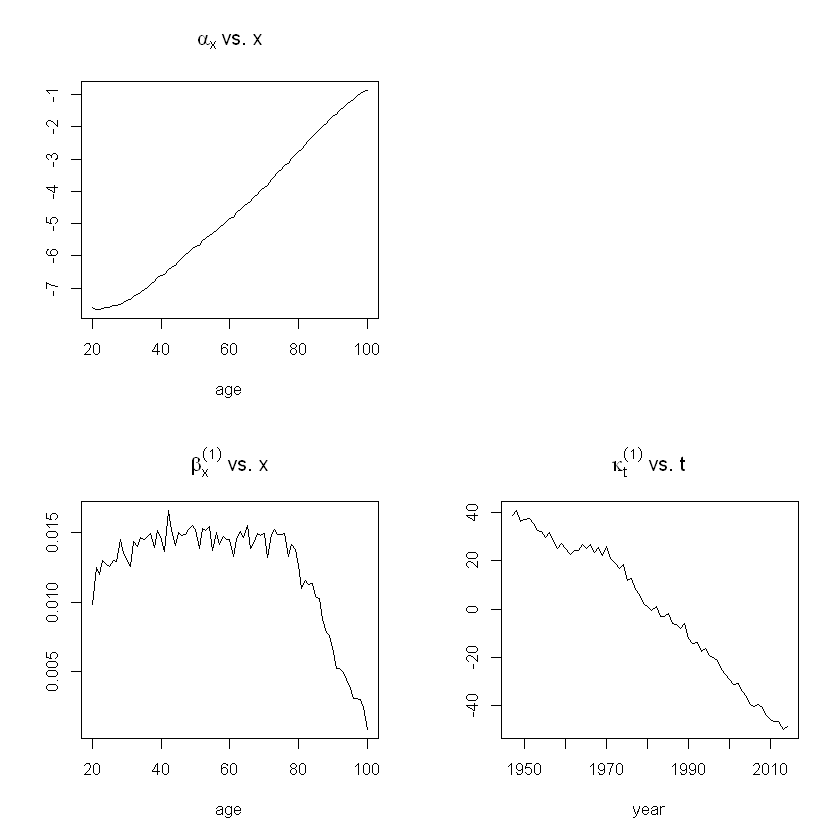

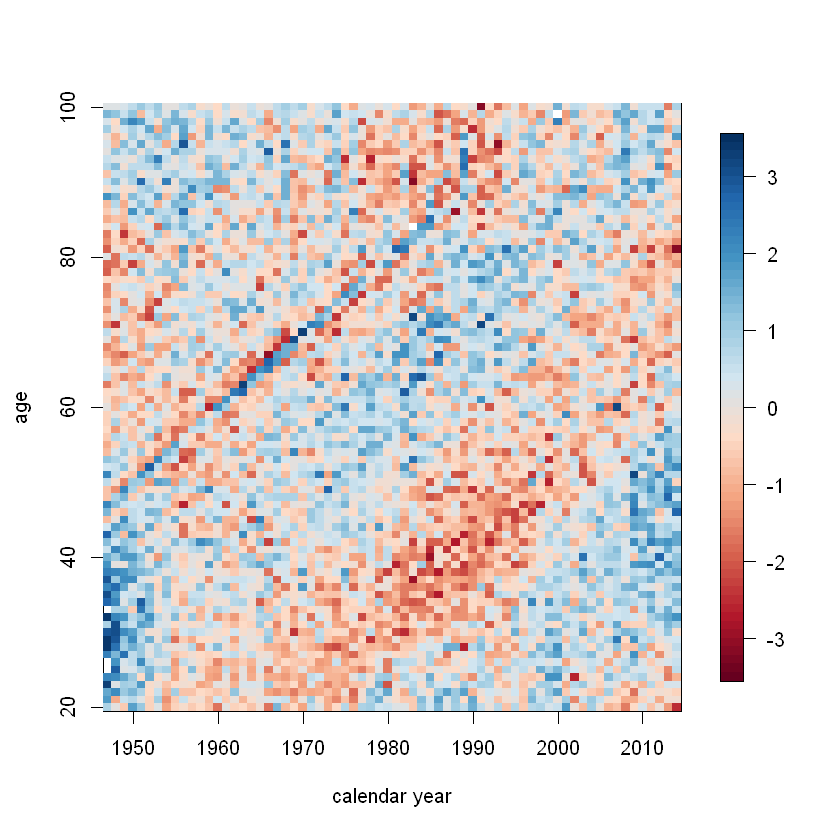

In [4]:
# Get HMD data for selected country
country_data <- hmd.mx(country=country, username=username, password=password)

# Loop over genders and fit Lee Carter model
D = list()
Dhat = list()
E = list()
y = list()

for (g in genders) {
  
  # Plot to see log death rate vs Age
  plot(country_data, series=g)
  
  # Lee-Carter fit
  mortality_data <- StMoMoData(country_data, series=g)
  
  LC <- lc(link='log')
  LCfit <- fit(LC, data=mortality_data, ages.fit=ages, years.fit=years)
  
  # Plot Lee-Carter coefficiets
  plot(LCfit)
  
  # Residuals vs year and age heatmap
  LCres <- residuals(LCfit)
  plot(LCres, type="colourmap", reslim = c(-3.5, 3.5))
  
  
  # Collect deaths, predicted deaths, exposure (population) and ratio
  D[[g]] <- LCfit$Dxt
  Dhat[[g]] <- fitted(LCfit, type = "deaths")
  E[[g]] <- LCfit$Ext
  y[[g]] <- D[[g]] / Dhat[[g]]
  
}

## 3. Random Forest Correction
In this step we show that centeral death rates predicted by Lee-Carter can be corrected with Random Forest. 

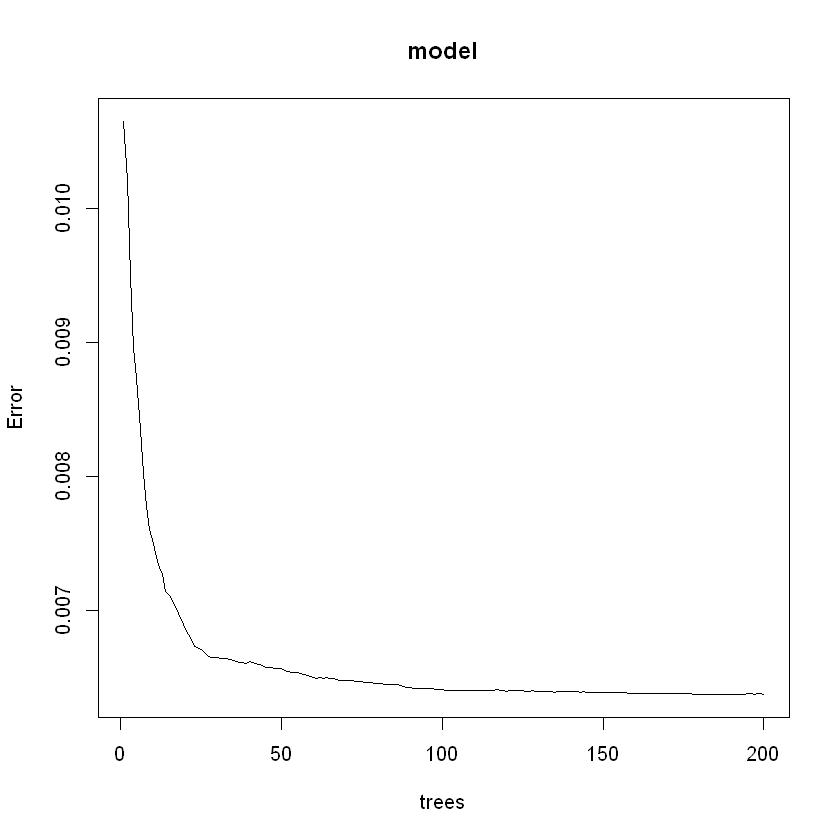

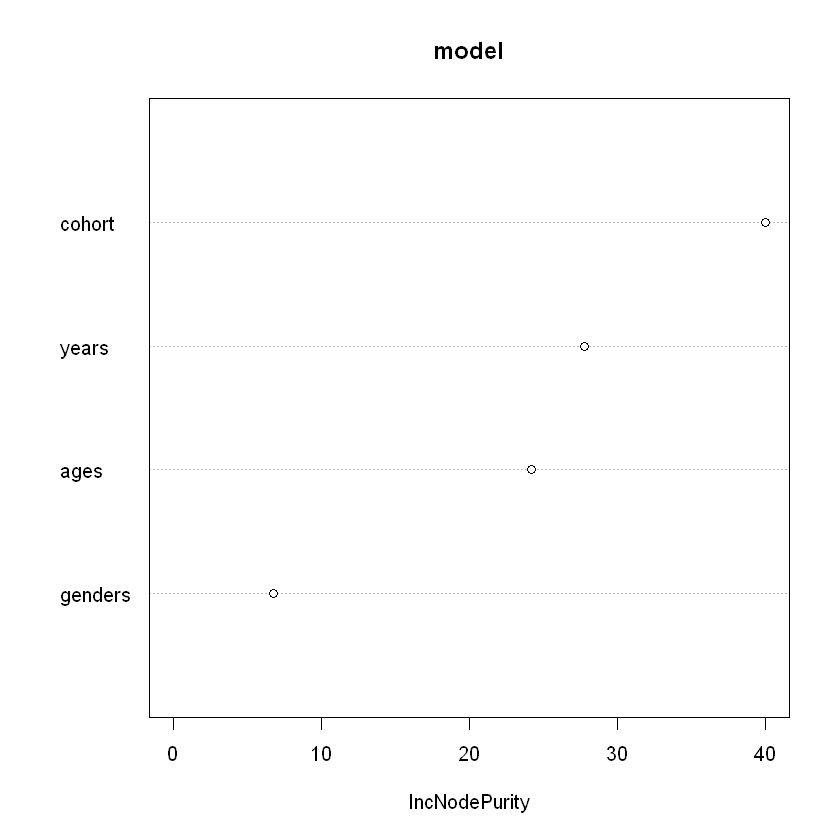

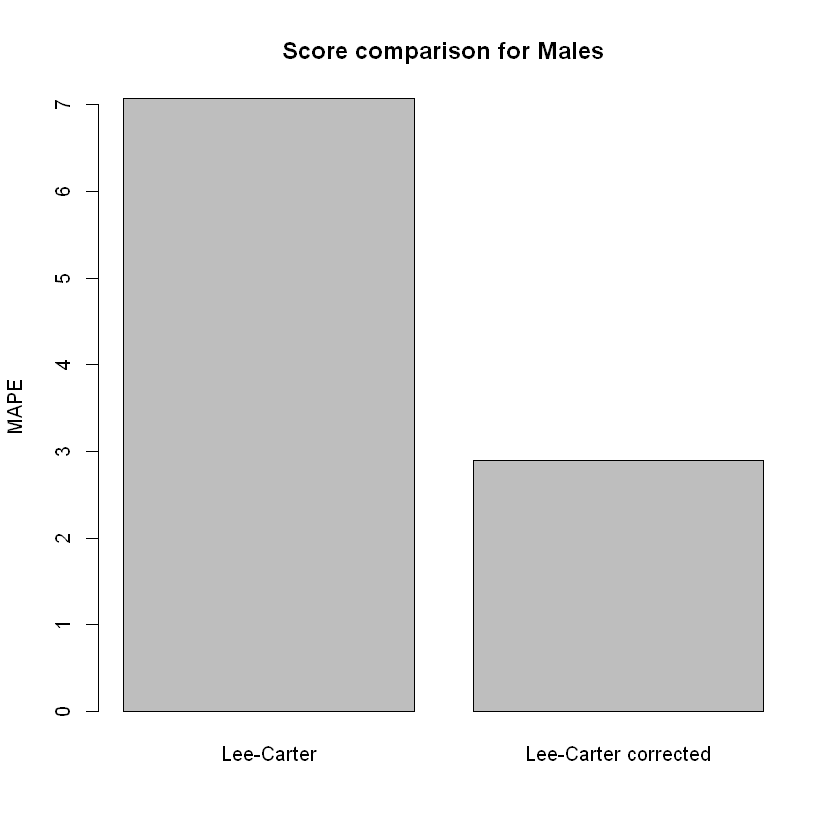

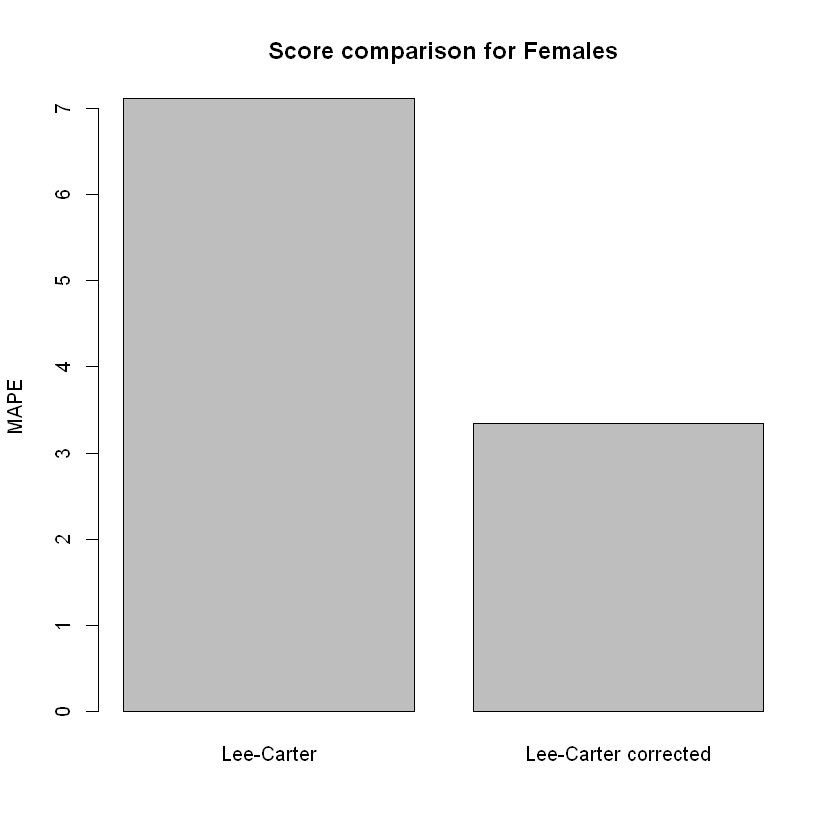

In [5]:
# Prepare data (with target defined as ratio Dx / Dx_hat)
# X * T * C * G = [20, 100] * [1947, 2014] * [1847, 1994] * [male, female]
data <- data.frame(matrix(ncol=8,nrow=0, 
                          dimnames=list(NULL, c("ages", "years", "cohort", "genders", "deaths", "deaths_LC", "population", "ratio"))))
i <- 1
for (x in ages) {
  for (t in years) {
    for (g in genders) {
      # Cohort is year - age
      c = t-x
      # Ordinal encoding for gender variable (0 - male, 1 - female)
      gen <- match(g, genders) - 1
      # Get deaths, population and predicted ratio 
      deaths <- D[[g]][toString(x), toString(t)]
      deaths_LC <- Dhat[[g]][toString(x), toString(t)]
      population <- E[[g]][toString(x), toString(t)]
      ratio <- y[[g]][toString(x), toString(t)]
      data[i,] <- c(x, t, c, gen, deaths, deaths_LC, population, ratio) 
      i <- i + 1
    }
  }
}

# Fit RF ratio ~ ages + years + cohort + genders
model <- randomForest(formula = ratio ~ ages + years + cohort + genders, data = data, ntree = 200, mtry = 2, importance = TRUE) 
plot(model) # Plot training history
varImpPlot(model, type=2) # Plot variable importances plot

# Predict to get ratios on training data
ratio_pred <- predict(model, newdata = data)

# Calculate original central death rates
rates <- data$deaths / data$population

# Calculate central death rates estimated by the Lee–Carter model
rates_LC <- data$deaths_LC / data$population

# Calculate central death rates estimated by the Lee–Carter model and corrected with Random Forest 
rates_pred <- ratio_pred * rates_LC

# Scores for males and females seperately
MAPE <- function(y_pred, y_true) {
  res <- 100 / length(y_pred) * sum(abs(y_true - y_pred) / y_true)
  return(res)
}

idx_male <- which(data$gender == 0)
idx_female <- which(data$gender == 1)

MAPE_male_LC <- MAPE(rates_LC[idx_male], rates[idx_male])
MAPE_male_corr <- MAPE(rates_pred[idx_male], rates[idx_male])
barplot(c(MAPE_male_LC, MAPE_male_corr), main="Score comparison for Males", ylab='MAPE',
        names.arg=c('Lee-Carter', 'Lee-Carter corrected'))

MAPE_female_LC <- MAPE(rates_LC[idx_female], rates[idx_female])
MAPE_female_corr <- MAPE(rates_pred[idx_female], rates[idx_female])
barplot(c(MAPE_female_LC, MAPE_female_corr), main="Score comparison for Females", ylab='MAPE',
        names.arg=c('Lee-Carter', 'Lee-Carter corrected'))

## 4. P-splines smoothing and extrapolation

Loading required package: svcm

Loading required package: Matrix

Loading required package: splines

Loading required package: lattice


Attaching package: 'lattice'


The following object is masked from 'package:gnm':

    barley




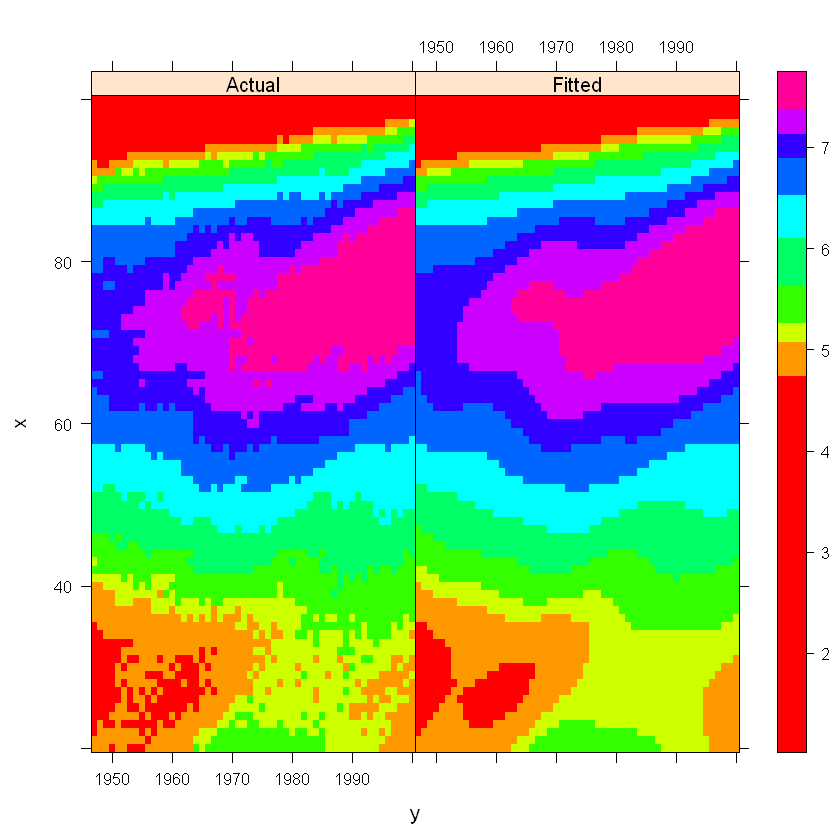

In [6]:
library(MortalitySmooth)

# Split data into training and extrapolation
data.train <- data[data$years <= 2000,]
data.val <- data[data$years > 2000,]

# Fit RF on training
model <- randomForest(formula = ratio ~ ages + years + cohort + genders, data = data.train, ntree = 200, mtry = 2, importance = TRUE)

# Predict on training
data.train_male <- data.train[data.train$genders == 0,]
ratio_pred <- predict(model, newdata = data.train_male)

# Collect deaths adjusted by Random Forest for p-splines 
years.train <- years[years <= 2000]
years.val <- years[years > 2000]
M <- matrix(, nrow = length(ages), ncol = length(years.train))
for (x in ages) {
  for (t in years.train) {
    M[match(x,ages),match(t,years.train)] = data.train_male$deaths[data.train_male$ages == x & data.train_male$years == t] / ratio_pred[data.train_male$ages == x & data.train_male$years == t]
  }
} 

# Smooth 
smooth <- Mort2Dsmooth(x=ages, y=years.train, Z=M)
plot(smooth)

# Extrapolate
smooth_pred <- predict(smooth, newdata=list(y=years.val), se.fit=TRUE)

## 5. Remarks

1. The predictions for 2001-2014 should be done from Random Forest and then smoothing should be applied i.e. no extrapolation should be done on smoothing side. Then, out-of-sample RMSE should be calculated.
2. For out-of-sample period 2001-2014, the true prediction would imply also Lee-Carter model forecasting to avoid overfitting on LC side. 
3. Instead of sensitivity of predictors analysis done in paper, the Explainable AI should be used.
4. Try other algorithms for example deep neural networks.